In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# 1. 데이터 로딩 및 전처리
df = pd.read_csv("./data/merged_label_final.csv")
df = df.dropna(subset=['content', 'label'])
df = df.sample(n=200000, random_state=42)  # 데이터 20만개만 사용

# 레이블 정수화
df['label'] = df['label'].astype(int)

# 한글 이외 제거
def clean_text(text):
    return re.sub(r"[^가-힣\s]", "", text)

df['content'] = df['content'].apply(clean_text)

# 2. 토크나이저 및 패딩
vocab_size = 20000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])
x = pad_sequences(sequences, maxlen=max_len)
y = to_categorical(df['label'])  # 3개 클래스

# 3. 학습/검증 분리
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# 4. 모델 정의 (1D CNN)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=max_len),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# 5. 학습
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))

# 6. 저장 (옵션)
model.save("cnn_sentiment_model2.h5")


In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import pickle

# 1. 데이터 로드
df = pd.read_csv("./data/merged_label_final.csv")
df = df.dropna(subset=["content", "label"])
df = df.sample(n=200000, random_state=42)  # 충분히 큰 데이터 사용

# 2. 텍스트 정제 함수
def clean_text(text):
    text = re.sub(r"[^가-힣\s]", "", text)
    return text.strip()

df["content"] = df["content"].apply(clean_text)

# 3. 너무 짧은 문장, 반복 텍스트 제거
def is_valid(text):
    # 너무 짧은 문장 제거
    if len(text.split()) < 3:
        return False
    # 반복 단어 비율이 높을 경우 제거
    words = text.split()
    repeat_ratio = len(set(words)) / len(words)
    return repeat_ratio > 0.5

df = df[df["content"].apply(is_valid)]

# 4. 라벨 처리
df["label"] = df["label"].astype(int)
y = to_categorical(df["label"], num_classes=3)

# 5. 토큰화 및 시퀀싱
vocab_size = 20000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df["content"])
sequences = tokenizer.texts_to_sequences(df["content"])
x = pad_sequences(sequences, maxlen=max_len)

# 6. train/val 분리
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# 7. 모델 정의 (Conv1D + L2 정규화)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=max_len),
    tf.keras.layers.Conv1D(256, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(
        64, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(3, activation='softmax')
])

# 8. 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# EarlyStopping 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop]
)

# 9. 저장
model.save("cnn_sentiment_model_v2.h5")
with open("tokenizer_v2.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# 10. 예시 출력
print("훈련 데이터 개수:", len(df))
print("샘플 문장:", df["content"].iloc[0])


In [ ]:
# 1. 필요 라이브러리
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pickle

# 2. 학습에 사용한 데이터 로딩 및 전처리 (Tokenizer 재정의 목적)
df = pd.read_csv("./data/merged_label_final.csv")  # 경로는 필요 시 수정
df = df.dropna(subset=['content', 'label'])
df = df.sample(n=100000, random_state=42).reset_index(drop=True)
df['label'] = df['label'].astype(int)

def clean_text(text):
    return re.sub(r"[^가-힣\s]", "", str(text))

df['content'] = df['content'].apply(clean_text)

# 3. Tokenizer 재정의 및 저장 (※ 학습 시 설정과 동일해야 함)
vocab_size = 20000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['content'])

# 저장 (선택사항)
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# 4. 모델 로드
model = tf.keras.models.load_model("cnn_sentiment_model.h5")

# 5. 감성 예측 함수 정의
def predict_sentiment(text, tokenizer, max_len=100):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    label = np.argmax(pred, axis=1)[0]
    label_name = {0: "부정", 1: "중립", 2: "긍정"}
    return label_name[label], float(np.max(pred))
    
# 6. 예측 테스트
example_texts = [
    "이 게임 진짜 최고에요! 완전 재미있어요.",
    "그럭저럭 할만해요.",
    "이게 게임이냐?"
]

for text in example_texts:
    label, confidence = predict_sentiment(text, tokenizer)
    print(f"[{text}] → 예측: {label} (신뢰도: {confidence:.2f})")


In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16222161993347496117
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5955182592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11546024607701395210
physical_device_desc: "device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle

# === 1. 데이터 로드 ===
df = pd.read_csv("./data/merged_label_final.csv")
df_subset = df.iloc[:300000]
df_subset = df.dropna(subset=['content', 'label'])

# 너무 짧은 문장 제거
df_subset['content_len'] = df_subset['content'].astype(str).apply(lambda x: len(x.split()))
df_subset = df_subset[df_subset['content_len'] >= 5]  # 5단어 이상

# 반복 문자 제거
def clean_text(text):
    text = re.sub(r"[^가-힣0-9\s]", "", str(text))     # 한글, 숫자, 공백만
    text = re.sub(r"(\w)\1{2,}", r"\1", text)           # 3회 이상 반복 제거
    return text

df_subset['content'] = df_subset['content'].apply(clean_text)

# === 2. 토크나이징 ===
vocab_size = 20000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_subset['content'])

sequences = tokenizer.texts_to_sequences(df_subset['content'])
x = pad_sequences(sequences, maxlen=max_len)
y = to_categorical(df_subset['label'].astype(int))

with open("tokenizer_final.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# === 3. Train/Test 분리 ===
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# === 4. 모델 구성 ===
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    Bidirectional(LSTM(32, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# === 5. 학습 ===
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=[early_stop]
)

model.save("cnn_bilstm_model.h5")
print("훈련 데이터 개수:", len(df_subset))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 bidirectional (Bidirectiona  (None, 96, 64)           41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0

1843/1843 [==============================] - 20s 10ms/step


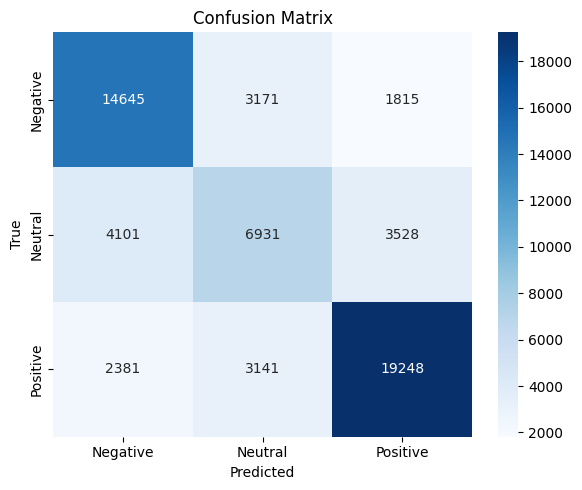

              precision  recall  f1-score    support
Negative          0.693   0.746     0.719  19631.000
Neutral           0.523   0.476     0.499  14560.000
Positive          0.783   0.777     0.780  24770.000
accuracy          0.692   0.692     0.692      0.692
macro avg         0.666   0.666     0.666  58961.000
weighted avg      0.689   0.692     0.690  58961.000


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# 모델 불러오기 (필요시)
model = load_model("cnn_bilstm_model.h5")

# x_val, y_val이 메모리에 있다고 가정합니다. 없다면 따로 로드하세요.

# 예측
y_pred_proba = model.predict(x_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

# 혼동행렬
labels = ["Negative", "Neutral", "Positive"]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification Report 출력
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).T
print(report_df.round(3))
